## Codon Usage Classification


Segundo a Wikipédia, códon é uma sequência de três bases nitrogenadas de RNA mensageiro que codificam um determinado aminoácido ou que indicam o ponto de início ou fim de tradução da cadeia de RNAm. A base de dados utilizada neste trabalho contém a frequência dos códons em diversos organismos e a qual reino eles pertencem. A ideia deste notebook é propor a identificação do reino do ser vivo através dos seus códons. A descrição dos dados é apresentada a seguir:

- Coluna 1: Reino
- Coluna 2: Tipo de DNA
- Coluna 3: ID da espécie
- Coluna 4: Ncódons
- Coluna 5: Nome da Espécie
- Colunas 6-69: códon (cabeçalho: bases de nucleotídeos; entradas: frequência de uso (número de ponto flutuante de 5 dígitos))

O 'Reino' é um código de 3 letras correspondente a 'xxx' no nome do banco de dados CUTG: 'arc'(archaea), 'bct'(bactéria), 'phg'(bacteriófago), 'plm' (plasmídeo), ' pln' (planta), 'inv' (invertebrado), 'vrt' (vertebrado), 'mam' (mamífero), 'rod' (roedor), 'pri' (primata) e 'vrl' (vírus) entradas de sequência . Observe que o banco de dados CUTG não contém 'arc' e 'plm' (estes foram selecionados manualmente).

O 'DNAtype' é indicado como um número inteiro para a composição genômica nas espécies: 0-genômico, 1-mitocondrial, 2-cloroplasto, 3-cianela, 4-plastídeo, 5-nucleomorfo, 6-secundário_endosimbionte, 7-cromoplasto, 8 -leucoplasto, 9-NA, 10-proplastídeo, 11-apicoplasto e 12-cinetoplasto.

O identificador da espécie ('SpeciesID') é um número inteiro, que indica exclusivamente as entradas de um organismo. É um identificador de acesso para cada espécie diferente no banco de dados CUTG original, seguido pelo primeiro item listado em cada genoma.

O número de códons (`Ncodons') é a soma algébrica dos números listados para os diferentes códons em uma entrada de CUTG. As frequências de códons são normalizadas para a contagem total de códons, portanto, o número de ocorrências dividido por 'Ncodons' são as frequências de códons listadas no arquivo de dados.

O nome da espécie ('SpeciesName') é representado em strings sem vírgula' (que agora são substituídas por espaço'). Este é um rótulo descritivo do nome da espécie para interpretações de dados.

Por último, as frequências de códons ('codon') incluindo 'UUU', 'UUA', 'UUG', 'CUU', etc., são registradas como floats (com casas decimais em 5 dígitos).
Source:

https://www.kaggle.com/datasets/meetnagadia/condon-usage-dataset?datasetId=1637292

https://archive.ics.uci.edu/ml/machine-learning-databases/00577/

In [43]:
import numpy as np
from numpy import set_printoptions
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Seleção de Atributos
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Treinamento do Modelo
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Leitura do Dataset

df = pd.read_csv("codon_usage.csv")
df

/tmp/ipykernel_15726/3189776298.py:3: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  object 
 1   DNAtype      13028 non-null  int64  
 2   SpeciesID    13028 non-null  int64  
 3   Ncodons      13028 non-null  int64  
 4   SpeciesName  13028 non-null  object 
 5   UUU          13028 non-null  object 
 6   UUC          13028 non-null  object 
 7   UUA          13028 non-null  float64
 8   UUG          13028 non-null  float64
 9   CUU          13028 non-null  float64
 10  CUC          13028 non-null  float64
 11  CUA          13028 non-null  float64
 12  CUG          13028 non-null  float64
 13  AUU          13028 non-null  float64
 14  AUC          13028 non-null  float64
 15  AUA          13028 non-null  float64
 16  AUG          13028 non-null  float64
 17  GUU          13028 non-null  float64
 18  GUC          13028 non-null  float64
 19  GUA 

In [4]:
# Verificando valores diferente de Float

df[~df['UUU'].str.contains('0').fillna(False)]

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
486,vrl,0,12440,1238,Non-A,non-B hepatitis virus,0.04362,0.02100,0.01292,0.01292,...,0.00081,0.00323,0.00242,0.00162,0.04443,0.01696,0.02423,0.02262,0.00162,0.00000
5063,bct,0,353569,1698,Salmonella enterica subsp. enterica serovar 4,12;I,-,0.02120,0.02356,0.01178,...,0.03062,0.00118,0.00707,0.00118,0.00000,0.02945,0.02356,0.04476,0.02473,0.00118
8192,pln,0,5516,7689,Fusarium culmorum,0.02068,0.02783,0.00117,0.01548,0.02302,...,0.00481,0.00637,0.00494,0.02380,0.03173,0.01834,0.03785,0.00130,0.00039,0.00130
8193,pln,0,5518,102185,Gibberella zeae,0.01818,0.02524,0.00279,0.01622,0.02284,...,0.00461,0.00730,0.00520,0.02769,0.03139,0.02001,0.03409,0.00094,0.00053,0.00069
8194,pln,1,5518,10769,mitochondrion Gibberella zeae,0.04652,0.01811,0.07902,0.00715,0.01272,...,0.00065,0.02294,0.00214,0.03036,0.00761,0.03296,0.00975,0.00176,0.00093,0.00994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [5]:
# Verificando valores diferente de Float

df[~df['UUC'].str.contains('0').fillna(False)]

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
5063,bct,0,353569,1698,Salmonella enterica subsp. enterica serovar 4,12;I,-,0.02120,0.02356,0.01178,...,0.03062,0.00118,0.00707,0.00118,0.00000,0.02945,0.02356,0.04476,0.02473,0.00118
8192,pln,0,5516,7689,Fusarium culmorum,0.02068,0.02783,0.00117,0.01548,0.02302,...,0.00481,0.00637,0.00494,0.02380,0.03173,0.01834,0.03785,0.00130,0.00039,0.00130
8193,pln,0,5518,102185,Gibberella zeae,0.01818,0.02524,0.00279,0.01622,0.02284,...,0.00461,0.00730,0.00520,0.02769,0.03139,0.02001,0.03409,0.00094,0.00053,0.00069
8194,pln,1,5518,10769,mitochondrion Gibberella zeae,0.04652,0.01811,0.07902,0.00715,0.01272,...,0.00065,0.02294,0.00214,0.03036,0.00761,0.03296,0.00975,0.00176,0.00093,0.00994
8195,pln,0,55183,2486,Forsythia x intermedia,0.02977,0.02615,0.00885,0.02212,0.02132,...,0.00282,0.01569,0.00724,0.03500,0.01408,0.03862,0.03218,0.00201,0.00040,0.00080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [6]:
# Sustituir valores valores fora do padrão por NaN
df['UUU']=df['UUU'].replace(['non-B hepatitis virus','12;I'],'NaN')
df['UUC']=df['UUC'].replace('-','NaN')
df['UUU'] = df['UUU'].astype('float32')
df['UUC'] = df['UUC'].astype('float32')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  object 
 1   DNAtype      13028 non-null  int64  
 2   SpeciesID    13028 non-null  int64  
 3   Ncodons      13028 non-null  int64  
 4   SpeciesName  13028 non-null  object 
 5   UUU          13026 non-null  float32
 6   UUC          13027 non-null  float32
 7   UUA          13028 non-null  float64
 8   UUG          13028 non-null  float64
 9   CUU          13028 non-null  float64
 10  CUC          13028 non-null  float64
 11  CUA          13028 non-null  float64
 12  CUG          13028 non-null  float64
 13  AUU          13028 non-null  float64
 14  AUC          13028 non-null  float64
 15  AUA          13028 non-null  float64
 16  AUG          13028 non-null  float64
 17  GUU          13028 non-null  float64
 18  GUC          13028 non-null  float64
 19  GUA 

In [8]:
# Verificando a existência de nulos

df.isnull().sum().sort_values(ascending=False)

UUU        2
UUC        1
Kingdom    0
UAU        0
UGU        0
          ..
GGU        0
GGC        0
GGA        0
GGG        0
UGA        0
Length: 69, dtype: int64

In [9]:
#Eliminando osdados nulos

df.dropna(inplace=True)

In [10]:
# Estatistica Descritiva dos Dados

df.describe()

,DNAtype,SpeciesID,Ncodons,UUU,UUC,UUA,UUG,CUU,CUC,CUA,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
count,13026.000000,13026.000000,1.302600e+04,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,...,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000,13026.000000
mean,0.367265,130443.036926,7.961776e+04,0.024818,0.023440,0.020637,0.014104,0.017821,0.018287,0.019045,...,0.005453,0.009930,0.006423,0.024181,0.021164,0.028291,0.021683,0.001640,0.000590,0.006179
std,0.688764,124777.067741,7.197556e+05,0.017628,0.011598,0.020710,0.009280,0.010587,0.014573,0.024252,...,0.006601,0.008574,0.006388,0.013826,0.013039,0.014343,0.015019,0.001785,0.000882,0.010345
min,0.000000,7.000000,1.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28851.250000,1.602000e+03,0.013910,0.015380,0.005610,0.007103,0.010890,0.007830,0.005302,...,0.001220,0.001690,0.001170,0.012390,0.011860,0.017360,0.009710,0.000560,0.000000,0.000410
50%,0.000000,81971.500000,2.929000e+03,0.021750,0.021905,0.015260,0.013360,0.016130,0.014560,0.009680,...,0.003530,0.009270,0.004545,0.025425,0.019070,0.026085,0.020540,0.001380,0.000420,0.001130
75%,1.000000,222890.500000,9.120000e+03,0.031307,0.029210,0.029495,0.019808,0.022730,0.025110,0.017255,...,0.007150,0.015928,0.010250,0.034190,0.027690,0.036800,0.031128,0.002370,0.000830,0.002890
max,12.000000,465364.000000,4.066258e+07,0.217300,0.091690,0.151330,0.101190,0.089780,0.100350,0.163920,...,0.055540,0.098830,0.058430,0.185660,0.113840,0.144890,0.158550,0.045200,0.025610,0.106700


In [11]:
# distribuição das classes

print(df.groupby('Kingdom').size())

Kingdom
arc     126
bct    2919
inv    1345
mam     572
phg     220
plm      18
pln    2523
pri     180
rod     215
vrl    2831
vrt    2077
dtype: int64


In [12]:
# Enconding da classe

df['Kingdom'] = LabelEncoder().fit_transform(df['Kingdom'])
df['Kingdom']

0        9
1        9
2        9
3        9
4        9
        ..
13023    7
13024    7
13025    7
13026    7
13027    7
Name: Kingdom, Length: 13026, dtype: int64

In [13]:
# Eliminação das colunas de nome e id da espécie

dataset = df.drop(['SpeciesName', 'SpeciesID'], axis=1)
Attr = df.drop(['Kingdom','SpeciesName', 'SpeciesID'], axis=1)
y = df['Kingdom']

In [14]:
dataset.head()

,Kingdom,DNAtype,Ncodons,UUU,UUC,UUA,UUG,CUU,CUC,CUA,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,9,0,1995,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,9,0,1474,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,9,0,4862,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,9,0,1915,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,9,0,22831,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


### Seleção de Atributos 

Seleção dos 50 melhores atributos baseados em teste Qui quadrado

In [15]:
 np.array(Attr.columns)

array(['DNAtype', 'Ncodons', 'UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC',
       'CUA', 'CUG', 'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA',
       'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU', 'CCC', 'CCA', 'CCG',
       'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC', 'UCA', 'UCG',
       'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC', 'CAA',
       'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA',
       'GAG', 'UAA', 'UAG', 'UGA'], dtype=object)

In [16]:
# Função para seleção de atributos
best_var = SelectKBest(score_func=chi2, k=50)
feature = np.array(Attr.columns)

# Executa a função de pontuação em (X, Y) e obtém os atributos selecionados
fit = best_var.fit(Attr, y)
filter = best_var.get_support()

# Reduz X para os atributos selecionados
features_data = fit.transform(Attr)

# Resultados
print('\nNúmero original de atributos:', Attr.shape[1])
print('\nNúmero reduzido de atributos:', features_data.shape[1])

# Exibe os atributos originais
print("\nAtributos Originais:", df.columns[0:69])

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas): plas, test, mass e age.
# (Basta mapear manualmente o índice dos nomes dos respectivos atributos)
set_printoptions(precision=3) # 3 casas decimais
print(fit.scores_)

# Imprime o dataset apenas com as colunas selecionadas

print("Selected best 30:")
print(feature[filter])

selected_attr = feature[filter]


Número original de atributos: 66

Número reduzido de atributos: 50

Atributos Originais: Index(['Kingdom', 'DNAtype', 'SpeciesID', 'Ncodons', 'SpeciesName', 'UUU',
       'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU',
       'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC',
       'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC',
       'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG',
       'UAA', 'UAG', 'UGA'],
      dtype='object')
[4.663e+03 9.654e+08 1.411e+01 1.978e+01 1.539e+01 2.242e+01 1.806e+01
 4.554e+01 2.284e+02 3.107e+01 1.362e+01 4.150e+01 3.851e+01 8.525e+00
 1.179e+01 5.520e+00 4.164e+00 1.463e+01 7.571e+00 3.176e+01 5.974e+00
 7.029e+01 6.444e+00 1.777e+01 2.275e+01 3.569e+01 1.302e+01 1.824e+01
 3.062e+01 9.980e+00 1.815e+00 1.551e+

In [17]:
# Selecionando os melhores atributos para as proximas fases

X = Attr[selected_attr]
X

,DNAtype,Ncodons,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,...,CGU,CGC,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UGA
0,0,1995,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,...,0.00401,0.00702,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00000
1,0,1474,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,...,0.00136,0.00678,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00000
2,0,4862,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,...,0.00864,0.00596,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00144
3,0,1915,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,...,0.00627,0.00261,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00000
4,0,22831,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,...,0.00950,0.00429,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,0,1097,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,...,0.00182,0.00547,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00638
13024,1,2067,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,...,0.00097,0.00726,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.01887
13025,1,1686,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,...,0.00119,0.00830,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.02017
13026,0,40662582,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,...,0.00454,0.01042,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00156


## Análise Exploratória

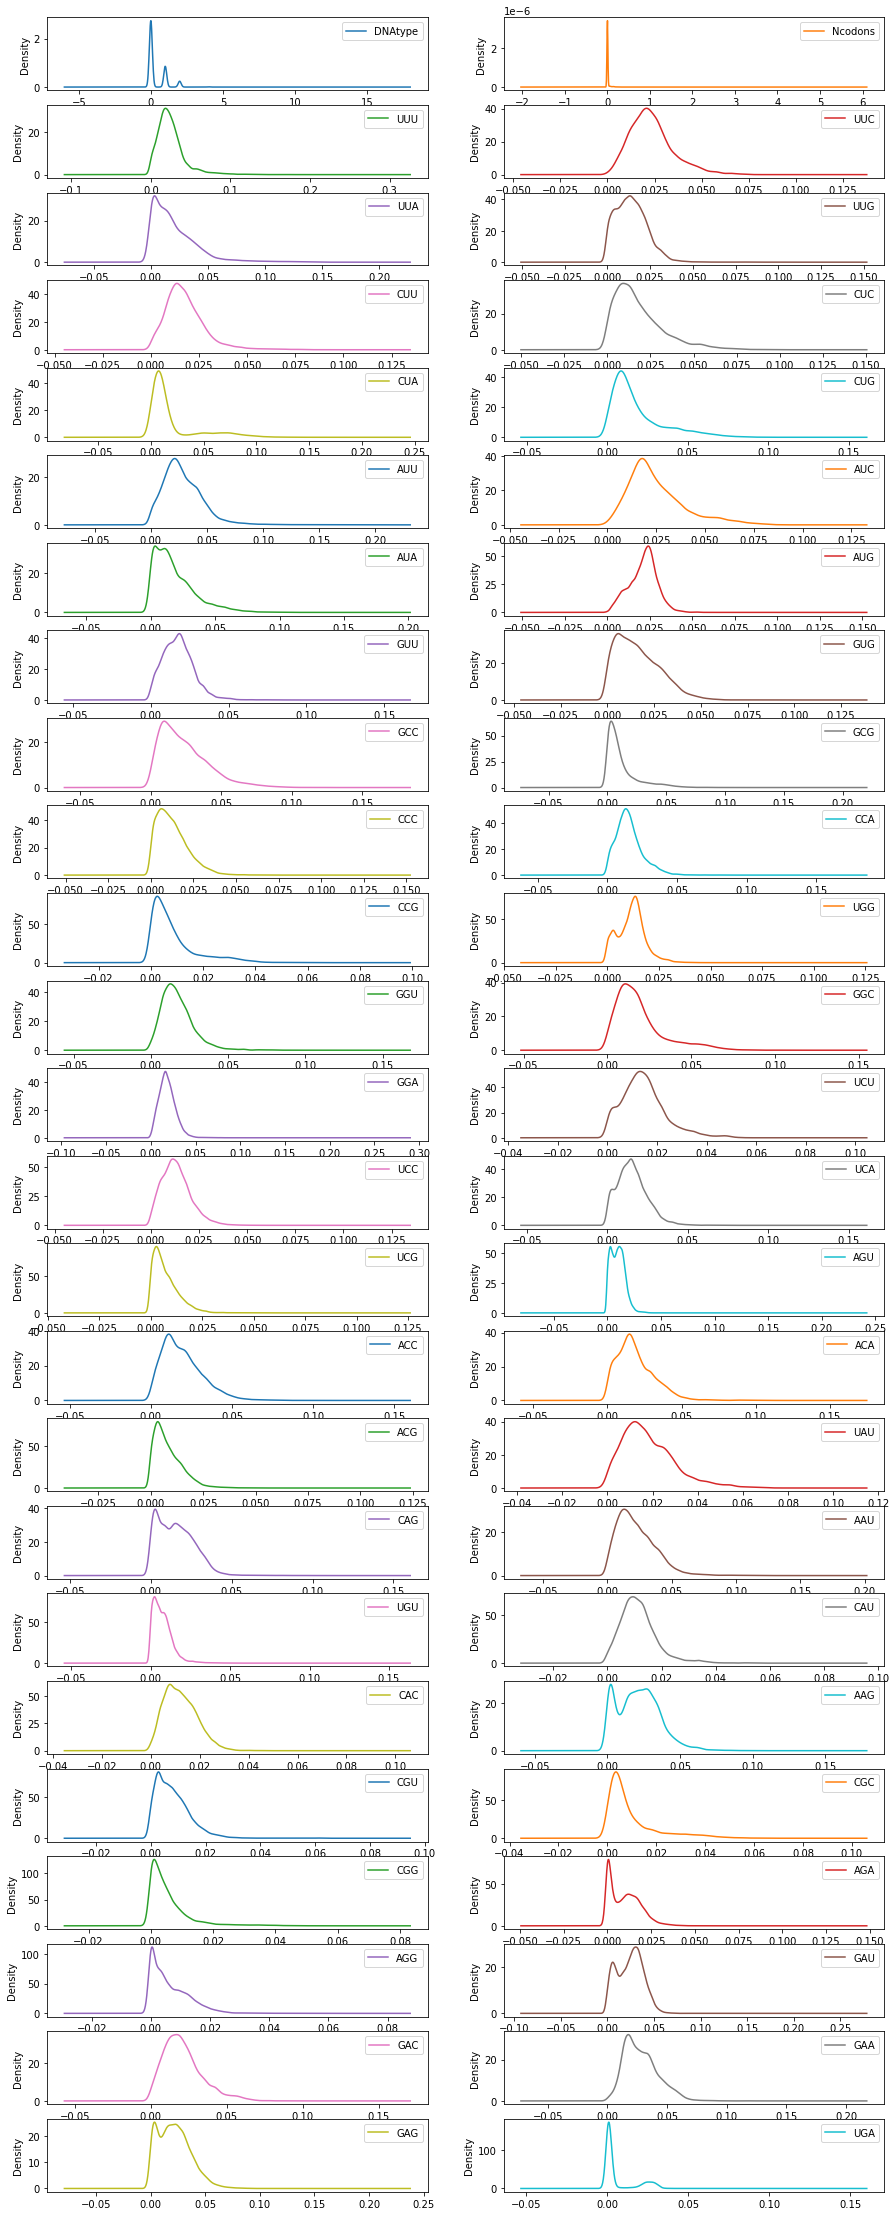

In [18]:
# Density Plot somente com as featurs de entrada
X.plot(kind = 'density', subplots = True, layout = (25,2), sharex = False, figsize = (15,40))
plt.show()

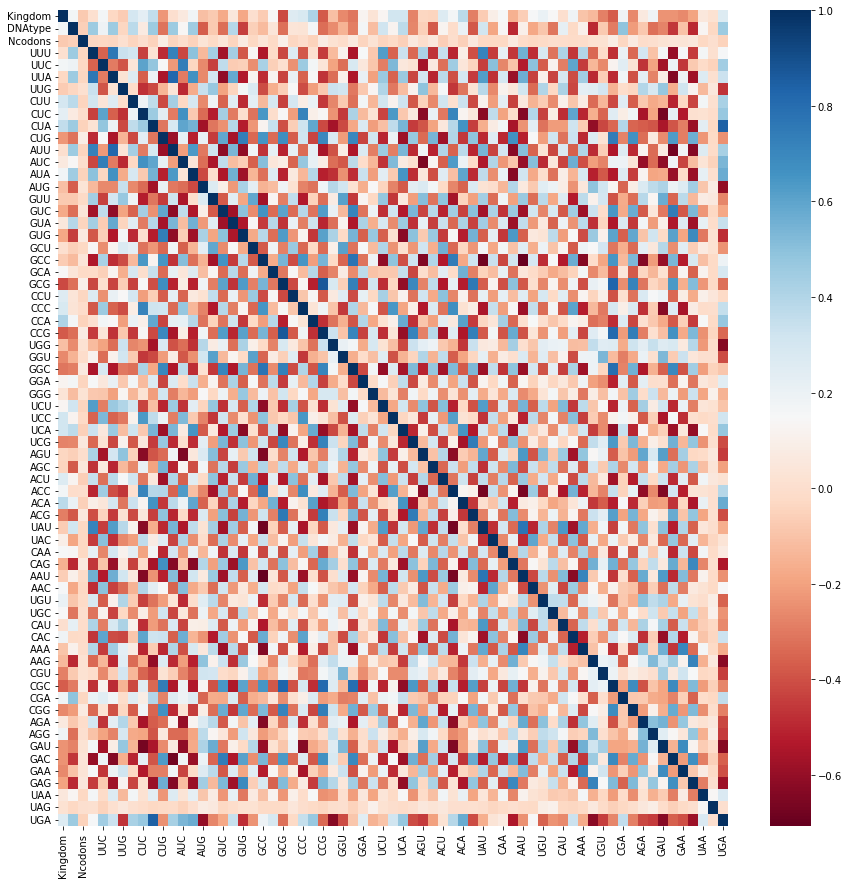

In [19]:
# Matriz de Correlação com Matplotlib Seaborn incluindo a classe de predição
plt.rcParams["figure.figsize"] = (15,15)

sns.heatmap(dataset.corr(), annot=False, cmap='RdBu');

## Separação do Conjunto de Treino e Teste

In [20]:
test_size = 0.20
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, random_state=seed)

## Treino dos Modelos

In [23]:

# definindo a métrica de avaliação dos algoritmos
scoring = 'accuracy'

num_folds = 10 # número de folds da validação cruzada

kfold = StratifiedKFold(n_splits=num_folds)

num_trees = 100
base = DecisionTreeClassifier()

In [26]:
np.random.seed(7) # definindo uma semente global

# Criação do Pipeline com Normalização

pipelines = []
pipelines.append(('RandomForest', Pipeline([('Scaler', MinMaxScaler()),
                                            ('RF', RandomForestClassifier(n_estimators=num_trees,
                                                                         random_state=seed))]))) 

pipelines.append(('Bagging', Pipeline([('Scaler', MinMaxScaler()),
                                       ('BG', BaggingClassifier(base_estimator=base, n_estimators=num_trees,
                                                               random_state=seed))]))) 

pipelines.append(('KNN', Pipeline([('Scaler', MinMaxScaler()),
                                   ('KNN', KNeighborsClassifier())])))

pipelines.append(('CART', Pipeline([('Scaler', MinMaxScaler()),
                                    ('CART', DecisionTreeClassifier(random_state=seed))])))

pipelines.append(('Logistic Regression', Pipeline([('Scaler', MinMaxScaler()),
                                                   ('LR', LogisticRegression(solver='liblinear',
                                                                            random_state=seed))]))) 
pipelines.append(('SVM', Pipeline([('Scaler', MinMaxScaler()),('SVM', SVC(gamma='auto'))])))

results = []
names = []
for name, model in pipelines:
    kfold = StratifiedKFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RandomForest: 0.887812 (0.008080)
Bagging: 0.876392 (0.008960)
KNN: 0.903647 (0.006208)
CART: 0.761708 (0.008223)
Logistic Regression: 0.794722 (0.009534)
SVM: 0.703935 (0.012337)


### Gridsearch com os Dois Melhores Modelos

In [27]:
def gridsearch(X_train, Y_train, model, param_grid, scoring, kfold):
    
    pipe = Pipeline([('Scaler', MinMaxScaler()), ('estimator', model)])
    
    # busca exaustiva de hiperparâmetros com GridSearchCV
    grid = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, Y_train)

    # imprime o melhor resultado
    print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_)) 

    # imprime todos os resultados
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f): %r" % (mean, stdev, param))

In [46]:
# Parameters of pipelines 
param_grid_knn = {
    'estimator__n_neighbors': [3,5,7,9,11,13,15,17,19,21],
    'estimator__metric': ["euclidean", "manhattan", "minkowski"],
}

param_grid_tree = {
    'estimator__bootstrap': [True, False],
    'estimator__criterion': ['gini', 'entropy', 'log_loss'],
    'estimator__max_depth': [3, 4, 5, 6, 7, 8]
}

In [31]:
# Modelo Random Forest

model_rf = RandomForestClassifier()
gridsearch(X_train, y_train, model_rf, param_grid_tree, scoring, kfold)

Melhor: 0.821881 usando {'estimator__bootstrap': False, 'estimator__criterion': 'entropy', 'estimator__max_depth': 8}
0.613916 (0.013436): {'estimator__bootstrap': True, 'estimator__criterion': 'gini', 'estimator__max_depth': 3}
0.672265 (0.014034): {'estimator__bootstrap': True, 'estimator__criterion': 'gini', 'estimator__max_depth': 4}
0.712572 (0.012202): {'estimator__bootstrap': True, 'estimator__criterion': 'gini', 'estimator__max_depth': 5}
0.752591 (0.010659): {'estimator__bootstrap': True, 'estimator__criterion': 'gini', 'estimator__max_depth': 6}
0.779175 (0.010482): {'estimator__bootstrap': True, 'estimator__criterion': 'gini', 'estimator__max_depth': 7}
0.807006 (0.008283): {'estimator__bootstrap': True, 'estimator__criterion': 'gini', 'estimator__max_depth': 8}
0.616123 (0.009413): {'estimator__bootstrap': True, 'estimator__criterion': 'entropy', 'estimator__max_depth': 3}
0.667083 (0.015465): {'estimator__bootstrap': True, 'estimator__criterion': 'entropy', 'estimator__max

In [47]:
# Modelo KNN

model_knn = KNeighborsClassifier()
gridsearch(X_train, y_train, model_knn, param_grid_knn, scoring, kfold)

Melhor: 0.913052 usando {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 3}
0.913052 (0.007473): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 3}
0.903647 (0.006208): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 5}
0.898081 (0.005850): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 7}
0.892610 (0.004730): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 9}
0.888292 (0.005777): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 11}
0.883109 (0.007050): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 13}
0.876967 (0.007369): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 15}
0.873129 (0.007554): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 17}
0.869482 (0.006649): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 19}
0.866891 (0.008786): {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 21}
0.913052 (0.005632): {'estimator__metric': 'manhattan', 

## Prediction

In [48]:
# KNN

model= KNeighborsClassifier(metric= 'euclidean', n_neighbors= 3).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[  2  12   2   0   0   1   2   0   0   2   1]
 [  6 363  66   9   8   2  65   0   1  66  15]
 [  7 104  35  13   3   0  34   1   1  50  17]
 [  1  41  13  37   3   0  10   2   3  12  13]
 [  0  15   2   0   9   0   5   0   0   8   0]
 [  0   0   0   0   0   0   1   0   0   2   0]
 [  7 166  61  12   7   3 143   0   0  63  24]
 [  1  15   3   3   0   0   6   0   0   5   5]
 [  0  12   2   8   0   0   5   0   9   3   2]
 [  8 175  63   8   9   0  85   1   0 196  22]
 [  4  93  36  16   2   0  39   1   5  30 183]]


In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.09      0.07        22
           1       0.36      0.60      0.45       601
           2       0.12      0.13      0.13       265
           3       0.35      0.27      0.31       135
           4       0.22      0.23      0.23        39
           5       0.00      0.00      0.00         3
           6       0.36      0.29      0.32       486
           7       0.00      0.00      0.00        38
           8       0.47      0.22      0.30        41
           9       0.45      0.35      0.39       567
          10       0.65      0.45      0.53       409

    accuracy                           0.37      2606
   macro avg       0.28      0.24      0.25      2606
weighted avg       0.39      0.37      0.37      2606



In [50]:
# Random Forest


model = RandomForestClassifier(bootstrap = False, criterion = 'entropy', 
                               max_depth = 8).fit(X_train, y_train)

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[  2   7   0   0   0   0   5   0   0   8   0]
 [  2 572   1   0   0   0  13   0   0  13   0]
 [  0  20 113   0   0   0  57   0   0  68   7]
 [  0   1   0  91   0   0   0   0   1   9  33]
 [  0  21   0   0  11   0   4   0   0   3   0]
 [  0   3   0   0   0   0   0   0   0   0   0]
 [  0   9   3   0   0   0 409   0   0  63   2]
 [  0   2   0   4   0   0   0   8   0   1  23]
 [  0   0   0  13   0   0   1   0   9   3  15]
 [  0  18   1   0   0   0  12   0   0 536   0]
 [  0   2   3   1   0   0   2   0   0  17 384]]


In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.09      0.15        22
           1       0.87      0.95      0.91       601
           2       0.93      0.43      0.59       265
           3       0.83      0.67      0.75       135
           4       1.00      0.28      0.44        39
           5       0.00      0.00      0.00         3
           6       0.81      0.84      0.83       486
           7       1.00      0.21      0.35        38
           8       0.90      0.22      0.35        41
           9       0.74      0.95      0.83       567
          10       0.83      0.94      0.88       409

    accuracy                           0.82      2606
   macro avg       0.77      0.51      0.55      2606
weighted avg       0.83      0.82      0.80      2606

